# LSTM encoder decoder

This notebook demonstrates use of an LSTM encoder-decoder model to predict electricty usage.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
from energy_data import import_energy_data
from ts_utils import create_sliding_window
from sklearn.model_selection import TimeSeriesSplit

from models.lstm_encoder_decoder import lstm_seq2seq

In [2]:
class ElectricityDataset(Dataset):
    
    def __init__(self,X,y):
        self.X,self.y = X,y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

In [3]:
def train_and_evaluate(model,dl_train,dl_valid,n_epochs,optimizer, loss_fn):
    training_losses = np.full(n_epochs, np.nan)
    eval_losses = np.full(n_epochs, np.nan)
    with tqdm(total=n_epochs) as tr:
        for epoch in range(n_epochs):
            train_loss = model.train_single_epoch(dl_train, optimizer, loss_fn)
            eval_loss = model.evaluate(dl_valid, loss_fn)
            # loss for epoch 
            training_losses
            training_losses[epoch] = train_loss
            eval_losses[epoch] = eval_loss
            # progress bar 
            tr.set_postfix(eval_loss="{0:.5f}".format(eval_loss))
            tr.update()
    return training_losses,eval_losses

In [4]:
# example of a pure encoder-decoder based approach

In [5]:
# we'll use the electricity data for this, import:
energy_df = import_energy_data()

train_split = 0.7
n_train = int(train_split * len(energy_df))
n_test = len(energy_df) - n_train

features = ['log_energy_consumption']
feature_array = energy_df[features].values

# Fit Scaler only on Training features
scaler = StandardScaler()
scaler.fit(feature_array[:n_train])

# Transform on both Training and Test data
scaled_array = pd.DataFrame(scaler.transform(feature_array),
                            columns=features)

In [6]:
sequence_length = 24
output_size = 12
X, y = create_sliding_window(scaled_array, sequence_length,output_size=output_size)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [7]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).unsqueeze(2).float()
X_test = torch.tensor(X_test).float()
#y_test = torch.tensor(y_test).unsqueeze(2).float()

100%|█████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.94s/it, eval_loss=0.78538]


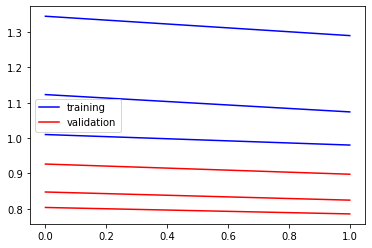

In [8]:
nfolds = 3
tscv = TimeSeriesSplit(n_splits=nfolds)
learning_rate = 0.01
n_epochs = 2
hidden_size = 5
loss_fn = nn.MSELoss()
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    # prep data
    X_tr, y_tr = X_train[torch.LongTensor(train_index)],y_train[torch.LongTensor(train_index)]
    X_v, y_v = X_train[torch.LongTensor(test_index)],y_train[torch.LongTensor(test_index)]
    dl_train = DataLoader(ElectricityDataset(X_tr, y_tr),batch_size=5)
    dl_valid = DataLoader(ElectricityDataset(X_v, y_v),batch_size=1)
    # model
    model = lstm_seq2seq(1, hidden_size)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    training_losses,eval_losses = train_and_evaluate(model,dl_train,dl_valid,n_epochs,optimizer, loss_fn)
    plt.plot(training_losses,label="training",color="blue")
    plt.plot(eval_losses,label="validation",color="red")
    if fold == 0:
        plt.legend()
plt.show()

In [9]:
n_epochs = 30
learning_rate = 0.01
model = lstm_seq2seq(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
for epoch in range(n_epochs):
     model.train_single_epoch(dl_train, optimizer, loss_fn)

## Inference

Predict on the test data

In [10]:
# inference
y_preds = []
for x in X_test:
    y_ = model.inference(x,output_size)
    y_preds.append(y_.squeeze())

In [11]:
def rmse_next_n_step(y_tests,y_preds,n):
    y_preds = [y[0:n] for y in y_preds]
    y_tests = [y[0:n] for y in y_tests]
    y_preds = np.concatenate(y_preds)
    y_tests = np.concatenate(y_tests)
    return np.sqrt(np.mean((y_preds-y_tests)**2))

In [12]:
for n in range(1,output_size+1):
    print(n,"RMSE: {0:.4f}".format(rmse_next_n_step(y_test,y_preds,n)))

1 RMSE: 0.6334
2 RMSE: 0.6787
3 RMSE: 0.7103
4 RMSE: 0.7315
5 RMSE: 0.7461
6 RMSE: 0.7564
7 RMSE: 0.7643
8 RMSE: 0.7714
9 RMSE: 0.7770
10 RMSE: 0.7810
11 RMSE: 0.7845
12 RMSE: 0.7878


In [13]:
np.std(np.concatenate(y_test))

0.8261978085059821

In [14]:
# some functions for plotting examples on original scale
# example
def reconstruct_ts(ts,start,stop):
    """
    reconstruct upto index n
    """
    n = stop-start
    out = np.full(n, np.nan)
    for t in range(n):
        out[t] = ts[start+t][0]
    return out

def inverse_transform(x):
    """
    x: np array
    """
    return np.exp(scaler.inverse_transform(x))
    
def plot_example_prediction(start,stop,output_size):
    y_obs = inverse_transform(reconstruct_ts(X_test,start,stop))
    y_pred = inverse_transform(y_preds[stop])
    y_truth = inverse_transform(reconstruct_ts(X_test,stop,stop+output_size))
    plt.plot(range(start,stop),y_obs)
    plt.plot(range(stop-1,stop+output_size),np.insert(y_pred,0,y_obs[-1]))
    plt.plot(range(stop-1,stop+output_size),np.insert(y_truth,0,y_obs[-1]),'--')
    plt.xlabel("time (hours)")
    plt.ylabel("energy usage")
    plt.show()

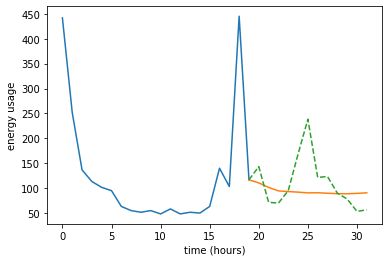

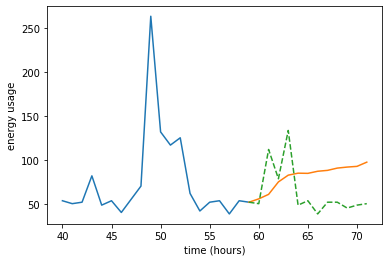

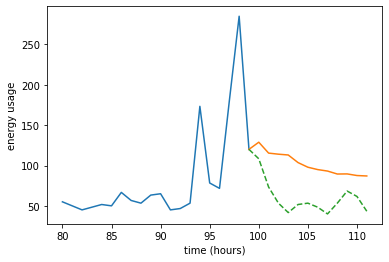

In [15]:
start_stops = [(0,20),(40,60),(80,100)]
for start_stop in start_stops:
    plot_example_prediction(start_stop[0],start_stop[1],output_size)

## The encoder

In [16]:
output, state = model.encoder(X_test[0:1])

In [17]:
# encoded state
state[0]

tensor([[[-0.6452,  0.0136,  0.2123,  0.0020, -0.1821]]],
       grad_fn=<StackBackward>)